See README.md for installs, environment setup

In [1]:
import sys
from multiprocessing import Pool
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import xlrd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# https://www.cvxpy.org/install/index.html
import cvxpy as cp

# set seed for reproducibility
np.random.seed(2347)

print("%-20s %s" % ('python', ".".join(map(str, sys.version_info[:3]))))
print("%-20s %s" % ("numpy", np.__version__))
print("%-20s %s" % ("pandas", pd.__version__))
print("%-20s %s" % ("pandas-datareader", pdr.__version__))
# print("%-20s %s" % ("xlrd", xlrd.__version__))
print("%-20s %s" % ("seaborn", sns.__version__))
print("%-20s %s" % ("matplotlib", matplotlib.__version__))
print("%-20s %s" % ("cvxpy", cp.__version__))


python               3.8.5
numpy                1.19.2
pandas               1.1.3
pandas-datareader    0.9.0
xlrd                 1.2.0
seaborn              0.11.0
matplotlib           3.3.2
cvxpy                1.1.7


# Get data

In [2]:
# load spreadsheet from Damodaran website into pandas dataframe
data_xls = 'http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
data_sheet = "Returns by year"
# these will change as rows get added on Damodaran website
skiprows = range(17)
skipfooter = 10
download_df = pd.read_excel('http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls', 
                         sheet_name=data_sheet, 
                         skiprows=skiprows,
                         skipfooter=skipfooter)
download_df = download_df.set_index('Year')

In [3]:
download_df

,S&P 500 (includes dividends),3-month T.Bill,US T. Bond,Baa Corporate Bond,S&P 500 (includes dividends)3,3-month T.Bill4,US T. Bond5,Baa Corporate Bond6,Stocks - Bills,Stocks - Bonds,Stocks - Baa Corp Bond,Historical risk premium,Inflation Rate,S&P 500 (includes dividends)2,3-month T. Bill (Real),!0-year T.Bonds,Baa Corp Bonds
Year,,,,,,,,,,,,,,,,,
1928,0.438112,0.030800,0.008355,0.032196,143.811155,103.080000,100.835471,103.219551,0.407312,0.429757,0.405916,NaN,-0.011522,0.454874,0.042815,0.020108,0.044227
1929,-0.082979,0.031600,0.042038,0.030179,131.877782,106.337328,105.074397,106.334569,-0.114579,-0.125018,-0.113158,NaN,0.000000,-0.082979,0.031600,0.042038,0.030179
1930,-0.251236,0.045500,0.045409,0.005398,98.745288,111.175676,109.845753,106.908543,-0.296736,-0.296646,-0.256634,NaN,-0.026712,-0.230686,0.074194,0.074101,0.032991
1931,-0.438375,0.023100,-0.025589,-0.156808,55.457774,113.743835,107.034958,90.144455,-0.461475,-0.412787,-0.281568,NaN,-0.089321,-0.383290,0.123448,0.069984,-0.074106
1932,-0.086424,0.010700,0.087903,0.235896,50.664911,114.960894,116.443660,111.409173,-0.097124,-0.174327,-0.322320,NaN,-0.103014,0.018495,0.126773,0.212842,0.377832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.013789,0.000525,0.012843,-0.006975,294115.792218,1984.403234,7061.887631,35838.083510,0.013264,0.000946,0.020764,0.045434,0.001186,0.012588,-0.000661,0.011643,-0.008152
2016,0.117731,0.003175,0.006906,0.103651,328742.282302,1990.703714,7110.653529,39552.738791,0.114556,0.110825,0.014080,0.046177,0.012616,0.103805,-0.009323,-0.005639,0.089901
2017,0.216055,0.009308,0.028017,0.097239,399768.635072,2009.233848,7309.873866,43398.808328,0.206746,0.188038,0.118816,0.047687,0.021301,0.190692,-0.011743,0.006576,0.074354


In [4]:
# load gold data from FRED API & save copy locally to CSV file

series = ['GOLDAMGBD228NLBM']

gold_download = pdr.data.DataReader(series, 
                                    'fred', 
                                    start='1968-12-31')
# convert daily to annual
gold_download = gold_download.resample('A').last().reset_index()
gold_download.set_index(pd.DatetimeIndex(gold_download['DATE']).year, inplace=True)
gold_download['return'] = gold_download['GOLDAMGBD228NLBM'].pct_change()
gold_download.to_csv('gold_fred.csv')


In [5]:
# splice older gold data from other sources (Ibbotson yearbook)
longrun_data = pd.DataFrame({'year': list(range(1928, 2020)), 'gold': [0,0,0,0,0,0.563618771,0.082920792,0,0,0,0,0,-0.014285714,0.028985507,0,0.028169014,-0.006849315,0.027586207,0.026845638,0.124183007,-0.023255814,-0.035714286,-0.00617284,-0.00621118,-0.0325,-0.082687339,-0.007042254,-0.002836879,0.001422475,0.001420455,0,0,0.035460993,-0.02739726,-0.004225352,-0.002828854,0.002836879,0.004243281,-0.002816901,0.002824859,0.225352113,-0.057471264,-0.051219512,0.146529563,0.431390135,0.667919799,0.725864012,-0.242041683,-0.03962955,0.204305898,0.291744258,1.205670351,0.296078431,-0.327618087,0.1175,-0.149888143,-0.189473684,0.061688312,0.195412844,0.244563827,-0.156937307,-0.022308911,-0.036907731,-0.085577421,-0.057057907,0.176426426,-0.021697511,0.009784736,-0.046511628,-0.222086721,0.005748128,0.005368895,-0.060637382,0.014120668,0.23960217,0.217359592,0.04397843,0.17768595,0.231968811,0.319224684,0.043178411,0.250359299,0.292413793,0.089292067,0.082625735,-0.273303167,0.00124533,-0.114238,0.091174,0.118540,-0.011454,0.188312]})
longrun_data.set_index('year', inplace=True)
longrun_data.loc[1969:, 'gold'] = gold_download['return']
longrun_data


,gold
year,
1928,0.000000
1929,0.000000
1930,0.000000
1931,0.000000
1932,0.000000
...,...
2015,-0.114238
2016,0.091174
2017,0.118540


In [6]:
series = ['GDPCA']

gdp_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1926-12-31')
gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()
# https://fortunly.com/statistics/us-gdp-by-year-guide/#gref
gdp_download.loc[1928, 'GDP'] = 0.0110
gdp_download.loc[1929, 'GDP'] = 0.0652
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1929,1929-01-01,1109.448,0.065200
1930,1930-01-01,1015.058,-0.085078
1931,1931-01-01,950.037,-0.064056
1932,1932-01-01,827.495,-0.128987
1933,1933-01-01,817.265,-0.012363
...,...,...,...
2016,2016-01-01,17730.509,0.017114
2017,2017-01-01,18144.105,0.023327
2018,2018-01-01,18687.786,0.029965


In [7]:
data_df = download_df.copy()
data_df = data_df.rename(columns = {'Inflation Rate': 'CPI',
           'S&P 500 (includes dividends)2': 'S&P',
           '3-month T. Bill (Real)': 'T-Bills',
           '!0-year T.Bonds': 'T-Notes',
           'Baa Corp Bonds': 'Baa Corps',
          })[['CPI', 'S&P', 'T-Bills', 'T-Notes', 'Baa Corps']]
data_df["GDP"] = gdp_download['GDP']
data_df["Gold"] = longrun_data['gold'] - data_df['CPI']
# reorder
data_df = data_df[['GDP', 'CPI', 'S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold']]


# Visualize

In [8]:
df = data_df
df

,GDP,CPI,S&P,T-Bills,T-Notes,Baa Corps,Gold
Year,,,,,,,
1928,0.011000,-0.011522,0.454874,0.042815,0.020108,0.044227,0.011522
1929,0.065200,0.000000,-0.082979,0.031600,0.042038,0.030179,0.000000
1930,-0.085078,-0.026712,-0.230686,0.074194,0.074101,0.032991,0.026712
1931,-0.064056,-0.089321,-0.383290,0.123448,0.069984,-0.074106,0.089321
1932,-0.128987,-0.103014,0.018495,0.126773,0.212842,0.377832,0.103014
...,...,...,...,...,...,...,...
2015,0.030755,0.001186,0.012588,-0.000661,0.011643,-0.008152,-0.115424
2016,0.017114,0.012616,0.103805,-0.009323,-0.005639,0.089901,0.078559
2017,0.023327,0.021301,0.190692,-0.011743,0.006576,0.074354,0.097239


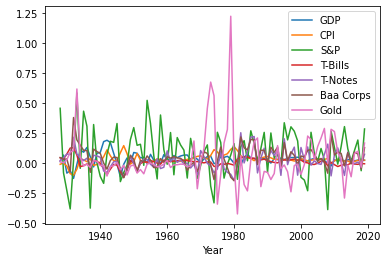

In [9]:
df.plot.line();


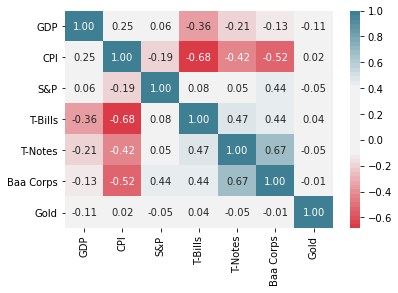

In [10]:
# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [11]:
# drop CPI, GDP which are not assets
df.drop(labels=['CPI', 'GDP'], axis=1, inplace=True)
# drop T-Notes, allocations are small, favors corps 
# df.drop(labels=['T-Notes'], axis=1, inplace=True)
labels = list(df.columns)
labels


['S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold']

# Long-only optimization

In [12]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.084127,0.004339,0.021667,0.042166,0.035419
vol,0.196194,0.035735,0.081270,0.086258,0.214474


In [13]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [14]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0.0195,0.9584,-0.0,-0.0,0.0221


In [15]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 348 ms, sys: 2.74 ms, total: 350 ms
Wall time: 349 ms


In [16]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df

,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.001241,0.006589,0.035227,0.019592,9.582865e-01,2.025991e-07,7.498202e-08,2.212160e-02
1,1,0.001428,0.013485,0.037790,0.060858,8.000160e-01,3.362386e-02,6.347475e-02,4.202695e-02
2,2,0.001615,0.016599,0.040191,0.073846,7.272852e-01,3.989620e-02,1.090606e-01,4.991165e-02
3,3,0.001802,0.019004,0.042456,0.083870,6.711318e-01,4.469729e-02,1.442994e-01,5.600162e-02
4,4,0.001990,0.021037,0.044606,0.092348,6.236290e-01,4.883879e-02,1.740314e-01,6.115316e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.037743,0.083675,0.194276,0.990703,9.619361e-09,1.908183e-08,7.293247e-08,9.296947e-03
196,196,0.037930,0.083789,0.194757,0.993045,8.659671e-09,1.711176e-08,6.446350e-08,6.954726e-03
197,197,0.038118,0.083902,0.195237,0.995375,1.996769e-08,3.936636e-08,1.460280e-07,4.624524e-03
198,198,0.038305,0.084015,0.195716,0.997694,3.939064e-09,7.563910e-09,2.453632e-08,2.306441e-03


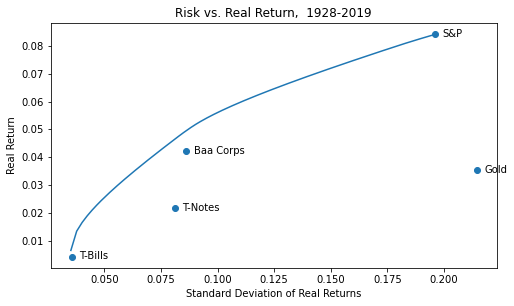

In [17]:
# plot efficient frontier
plt.figure(figsize=(8, 4.5))
plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")
plt.title("Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]))

# plot the data
plt.plot(x,y)

xoffset = 0.0033
yoffset = 0.002
for i, label in enumerate(labels):
    plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                horizontalalignment='left', verticalalignment='top',
               )


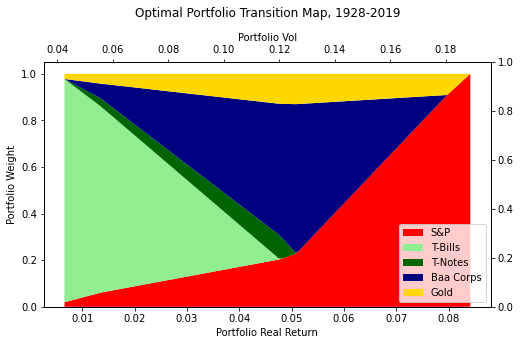

In [18]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
x = ret_df['return']
y_list = [ret_df[l] for l in labels]
pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold']

fig = plt.figure(figsize=(8, 4.5))
ax1 = fig.add_subplot(111)

ax1.stackplot(x, y_list, labels=labels, colors=pal)
ax1.set_xlabel("Portfolio Real Return")
ax1.set_ylabel("Portfolio Weight")
ax1.legend(loc='lower right')

ax2 = ax1.twiny()
ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
ax2.set_xlabel('Portfolio Vol')

ax3 = ax1.twinx()

plt.title("Optimal Portfolio Transition Map, %d-%d" % (df.index[0], df.index[-1]), y=1.16);


## 1972 - present (post gold standard)

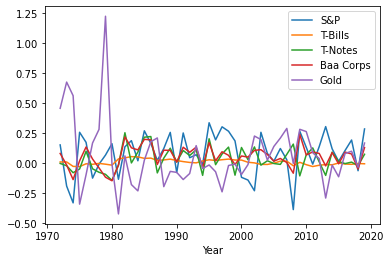

In [19]:
df = data_df.loc[1972:]
df.plot.line();


In [20]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.078742,0.006262,0.031453,0.053972,0.066433
vol,0.169315,0.021752,0.096007,0.087395,0.274351


In [21]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [22]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,-0.0,0.9737,-0.0,-0.0,0.0263


In [23]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 407 ms, sys: 3.53 ms, total: 411 ms
Wall time: 408 ms


In [24]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df

,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.000419,0.007846,0.020461,5.028821e-07,9.736600e-01,2.300512e-07,2.204702e-07,2.633901e-02
1,1,0.000561,0.015047,0.023677,3.058031e-02,8.440547e-01,7.575260e-09,7.816950e-02,4.719552e-02
2,2,0.000703,0.018498,0.026506,4.097358e-02,7.794407e-01,6.911135e-07,1.235058e-01,5.607927e-02
3,3,0.000845,0.021164,0.029061,4.903172e-02,7.294819e-01,1.212105e-04,1.584186e-01,6.294654e-02
4,4,0.000986,0.023418,0.031408,5.609421e-02,6.867541e-01,1.556291e-03,1.868129e-01,6.878242e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.028100,0.078652,0.167630,9.926941e-01,7.132547e-10,1.201880e-09,2.858661e-09,7.305916e-03
196,196,0.028242,0.078675,0.168053,9.945368e-01,9.828751e-10,1.639581e-09,3.778049e-09,5.463231e-03
197,197,0.028384,0.078697,0.168475,9.963685e-01,1.382701e-09,2.286996e-09,5.107815e-09,3.631489e-03
198,198,0.028526,0.078720,0.168896,9.981895e-01,2.305501e-09,3.823794e-09,8.435644e-09,1.810498e-03


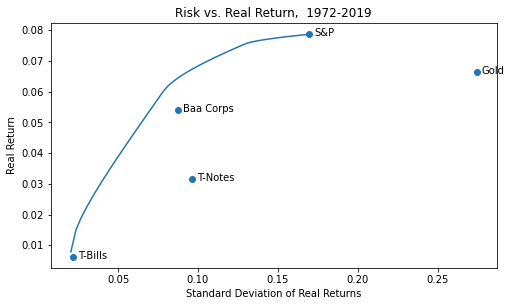

In [25]:
# plot frontier
plt.figure(figsize=(8, 4.5))
plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")
plt.title("Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]))

# plot the data
plt.plot(x,y)


xoffset = 0.0033
yoffset = 0.002
for i, label in enumerate(labels):
    plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                horizontalalignment='left', verticalalignment='top',
               )


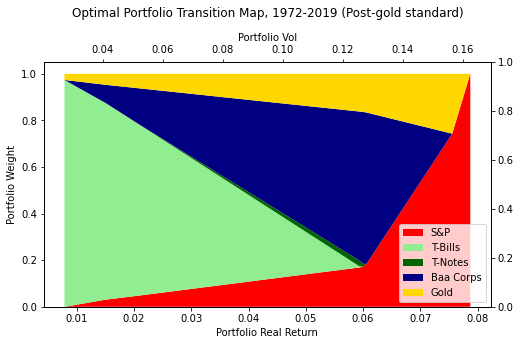

In [26]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
x = ret_df['return']
y_list = [ret_df[l] for l in labels]
pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold']

fig = plt.figure(figsize=(8, 4.5))
ax1 = fig.add_subplot(111)

ax1.stackplot(x, y_list, labels=labels, colors=pal)
ax1.set_xlabel("Portfolio Real Return")
ax1.set_ylabel("Portfolio Weight")
ax1.legend(loc='lower right')

ax2 = ax1.twiny()
ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
ax2.set_xlabel('Portfolio Vol')

ax3 = ax1.twinx()

plt.title("Optimal Portfolio Transition Map, %d-%d (Post-gold standard)" % (df.index[0], df.index[-1]), y=1.16);


## 1983 - present (post-inflation era)


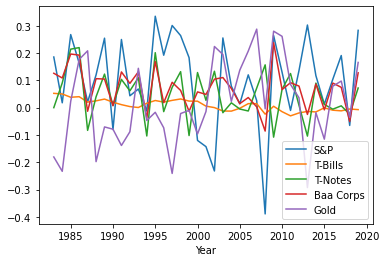

In [27]:
df = data_df.loc[1983:]
df.plot.line();

In [28]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.098443,0.008682,0.046194,0.070175,0.017639
vol,0.161492,0.020979,0.088223,0.072055,0.154153


In [29]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [30]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,-0.0,0.9423,0.0016,-0.0,0.0561


In [31]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 352 ms, sys: 2.74 ms, total: 355 ms
Wall time: 353 ms


In [32]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.000357,0.009246,0.018897,1.226115e-08,9.422270e-01,1.637618e-03,2.988593e-08,5.613534e-02
1,1,0.000486,0.017951,0.022053,1.110708e-02,8.006577e-01,3.387252e-02,1.069471e-01,4.741563e-02
2,2,0.000616,0.022238,0.024811,1.799945e-02,7.341659e-01,4.358201e-02,1.613390e-01,4.291371e-02
3,3,0.000745,0.025552,0.027292,2.335347e-02,6.827590e-01,5.111933e-02,2.033262e-01,3.944197e-02
4,4,0.000874,0.028355,0.029565,2.787780e-02,6.392933e-01,5.748892e-02,2.388360e-01,3.650402e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.025563,0.098075,0.159883,9.869773e-01,1.937133e-08,7.361091e-08,1.302263e-02,2.578218e-08
196,196,0.025692,0.098167,0.160287,9.902483e-01,1.969777e-08,7.467164e-08,9.751629e-03,2.622575e-08
197,197,0.025821,0.098259,0.160689,9.935090e-01,1.186389e-08,4.499842e-08,6.490948e-03,1.580099e-08
198,198,0.025950,0.098351,0.161091,9.967595e-01,1.009426e-09,4.035301e-09,3.240460e-03,1.405070e-09


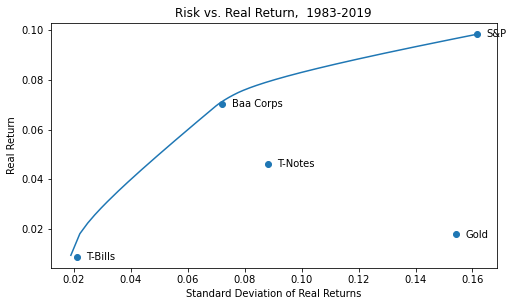

In [33]:
# plot frontier
plt.figure(figsize=(8, 4.5))
plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")
plt.title("Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]))

# plot the data
plt.plot(x,y)


xoffset = 0.0033
yoffset = 0.002
for i, label in enumerate(labels):
    plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                horizontalalignment='left', verticalalignment='top',
               )

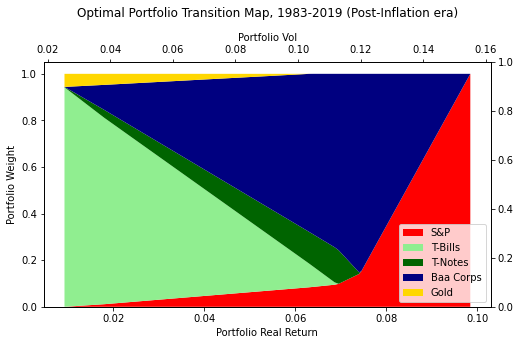

In [34]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
x = ret_df['return']
y_list = [ret_df[l] for l in labels]
pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold']

fig = plt.figure(figsize=(8, 4.5))
ax1 = fig.add_subplot(111)

ax1.stackplot(x, y_list, labels=labels, colors=pal)
ax1.set_xlabel("Portfolio Real Return")
ax1.set_ylabel("Portfolio Weight")
ax1.legend(loc='lower right')

ax2 = ax1.twiny()
ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
ax2.set_xlabel('Portfolio Vol')

ax3 = ax1.twinx()

plt.title("Optimal Portfolio Transition Map, %d-%d (Post-Inflation era)" % (df.index[0], df.index[-1]), y=1.16);


# Long/short optimization with leverage constraint

In [35]:
# in order to include shorts, we need an asset with a negative expected return
n = len(data_df)
target_corr = 0.6

def target_corr(x1, target_corr, mean_return):
    """given a series x1, return a random series with correlation target_corr to x1"""
    n = len(x1)
    theta = np.arccos(target_corr)
    
    x2 = np.random.normal(0, x1.std(), size=n)  
    # center so actual mean = 0
    X = pd.DataFrame({'x1': x1 - x1.mean(),
                      'x2': x2 - x2.mean()
                     })
    # identity matrix
    Id = np.diag(np.ones(n))
    # QR factorization
    Q = np.linalg.qr(X[['x1']])[0]
    P = Q @ Q.T
    x2o = (Id - P) @ X[['x2']]
    Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
    # divide by l2 norm
    Y = Xc2 / np.sqrt(np.sum(np.square(Xc2)))
    return Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return

stonks = target_corr(data_df['S&P'].values, 0.9, -0.05)
print("mean return %.04f" % stonks.mean())
print("vol %.04f" % stonks.std())
np.corrcoef(stonks, data_df['S&P'])



mean return -0.0500
vol 0.2405


array([[1. , 0.9],
       [0.9, 1. ]])

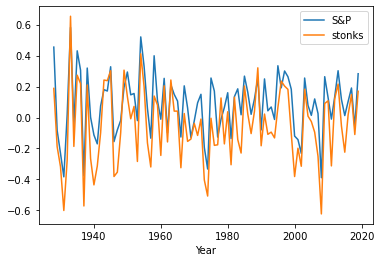

In [36]:
data_df['stonks'] = stonks.to_list()
labels = ['S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold', 'stonks']

df = data_df
df[['S&P', 'stonks']].plot.line();

In [37]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
rows,,,,,,
real return,0.084127,0.004339,0.021667,0.042166,0.035419,-0.050000
vol,0.196194,0.035735,0.081270,0.086258,0.214474,0.240493


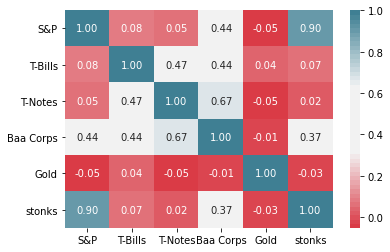

In [38]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [39]:
# Solve max return portfolio (corner solution)
# update constraints for leverage scenario
# sum of weights == 1 as before, net long 100%
# remove w >= 0 constraint
# new constraint on gross exposure <= 1.5, otherwise optimal weights are unbounded (go infinity long S&P, infinity short stonks)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights (return=%.4f, vol=%.4f)" % (maxret, maxretvol))
pd.DataFrame([wts], columns=labels)


Max return portfolio weights (return=0.1177, vol=0.0372)


,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,1.25,-0.0,0.0,0.0,0.0,-0.25


In [40]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights (return=%.4f, vol=%.4f)" % (minvolret, minvol))
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights (return=0.0074, vol=0.0012)


,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,0.0421,0.9821,0.0174,-0.0517,0.0225,-0.0124


In [41]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1,
                   vol <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


/Users/drucev/opt/anaconda3/envs/portfolio_opt2/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CPU times: user 434 ms, sys: 6.4 ms, total: 441 ms
Wall time: 438 ms


In [42]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,0,0.001231,0.007477,0.035085,0.042584,9.818622e-01,1.740242e-02,-5.160813e-02,2.249614e-02,-0.012736
1,1,0.001412,0.026968,0.037574,0.186726,9.135213e-01,1.736322e-02,-1.807365e-02,3.166073e-02,-0.131198
2,2,0.001593,0.035065,0.039908,0.246622,8.851683e-01,1.733720e-02,-4.168500e-03,3.546436e-02,-0.180423
3,3,0.001773,0.041279,0.042113,0.292551,8.633054e-01,1.733868e-02,6.583412e-03,3.839192e-02,-0.218170
4,4,0.001954,0.046517,0.044208,0.331290,8.448852e-01,1.734393e-02,1.560818e-02,4.086222e-02,-0.249990
...,...,...,...,...,...,...,...,...,...,...
195,195,0.036495,0.117213,0.191036,1.240832,4.182534e-10,8.927122e-10,2.150250e-09,9.167985e-03,-0.250000
196,196,0.036675,0.117325,0.191508,1.243142,3.578458e-10,7.521095e-10,1.642202e-09,6.858146e-03,-0.250000
197,197,0.036856,0.117437,0.191980,1.245440,6.369616e-09,1.267387e-08,2.120441e-08,4.560313e-03,-0.250000
198,198,0.037037,0.117549,0.192450,1.247726,2.311390e-09,4.153033e-09,5.137412e-09,2.274336e-03,-0.250000


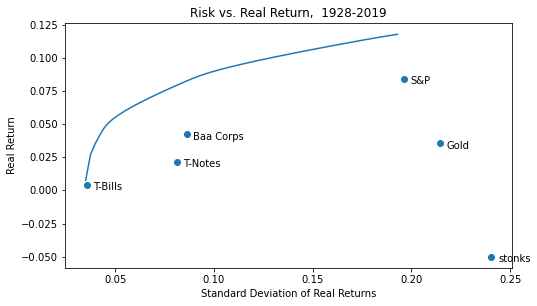

In [43]:
# plot frontier
plt.figure(figsize=(8, 4.5))
plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")
plt.title("Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]))

# plot the data
plt.plot(x,y)


xoffset = 0.0033
yoffset = 0.002
for i, label in enumerate(labels):
    plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                horizontalalignment='left', verticalalignment='top',
               )

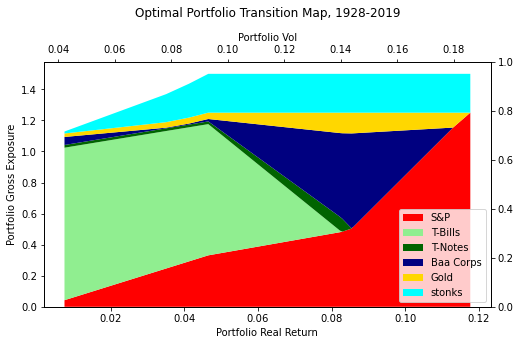

In [44]:
# stacked area chart of absolute exposures vs. returns
# for given vol constraint and corresponding real return, show portfolio absolute exposures
# plot absolute values so shorts don't create chaos

x = ret_df['return']
y_list = [abs(ret_df[l]) for l in labels]
pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold', 'cyan']

fig = plt.figure(figsize=(8, 4.5))
ax1 = fig.add_subplot(111)

ax1.stackplot(x, y_list, labels=labels, colors=pal)
ax1.set_xlabel("Portfolio Real Return")
ax1.set_ylabel("Portfolio Gross Exposure")
ax1.legend(loc='lower right')

ax2 = ax1.twiny()
ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
ax2.set_xlabel('Portfolio Vol')

ax3 = ax1.twinx()

plt.title("Optimal Portfolio Transition Map, %d-%d" % (df.index[0], df.index[-1]), y=1.16);


# Factors

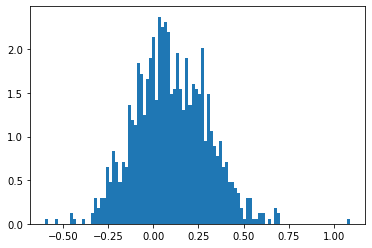

In [45]:
# number of stocks
n = 1000 
# historical mean returns for each stock
mu = np.random.normal(0.1, 0.2, n)

# number of factors
m = 10

# factor covariance matrix - random symmetrical matrix
SigmaFactor = np.random.randn(m, m)/4
SigmaFactor = SigmaFactor.T @ SigmaFactor

# factor loadings, determine volatility and covariances between stocks
F = np.random.randn(n, m)
# idiosyncratic risk of each stock
D = np.diag(np.random.uniform(0, 0.9, size=n))

count, bins, ignored = plt.hist(mu, 100, density=True, align='mid')


In [46]:
w = cp.Variable(n)         # what we solve for: weight for each stock
ret = mu.T @ w             # solve for weights that maximize portfolio return
f = F.T @ w                # portfolio factor loading
Lmax = cp.Parameter()      # leverage constraint
# portfolio volatility: factor risk + idiosyncratic risk
risk = cp.quad_form(f, SigmaFactor) + cp.quad_form(w, D)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
prob.solve(verbose=True)

maxretvol = risk.value
maxret = ret.value
print("Max return portfolio (return=%.4f, vol=%.4f)" % (maxret, maxretvol))



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -9.928e-02  -3.087e+00  +4e+01  2e-01  6e-01  1e+00  2e-02    ---    ---    1  1  - |  -  - 
 1  -2.165e-01  -1.045e+00  +3e+01  7e-02  3e-01  8e-01  1e-02  0.2895  3e-01   0  0  0 |  0  0
 2  -1.067e+00  -1.922e+00  +3e+01  3e-02  4e-01  1e+00  1e-02  0.0181  1e+00   0  0  0 |  0  0
 3  -1.453e+00  -1.582e+00  +1e+01  5e-03  1e-01  4e-01  6e-03  0.6238  6e-02   0  0  0 |  0  0
 4  -1.487e+00  -1.618e+00  +8e+00  4e-03  9e-02  3e-01  5e-03  0.3174  3e-01   1  1  1 |  0  0
 5  -1.510e+00  -1.642e+00  +8e+00  4e-03  9e-02  3e-01  5e-03  0.0203  9e-01   1  1  1 |  0  0
 6  -1.779e+00  -1.903e+00  +3e+00  1e-03  3e-02  4e-02  2e-03  0.9890  4e-01   1  1  1 |  0  0
 7  -1.922e+00  -1.926e+00  +1e-01  4e-05  1e-03  9e-04  6e-05  0.9722  7e-03   1  1  1 |  0  0
 8  -1.929e+00  -1.929e+00  +1e-03  4e-07  1e-

In [47]:
# solve min vol portfolio (other corner solution)

prob = cp.Problem(cp.Minimize(risk),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])
prob.solve(solver=cp.OSQP)

minvol = risk.value
minvolret = ret.value
print("Min vol portfolio (return=%.4f, risk=%.4f)" % (minvolret, minvol))


Min vol portfolio (return=0.1010, risk=0.0002)


In [48]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax,
                   risk <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve(verbose=False)
    return (ret.value, np.sqrt(risk.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


/Users/drucev/opt/anaconda3/envs/portfolio_opt2/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CPU times: user 1min 2s, sys: 657 ms, total: 1min 3s
Wall time: 8.12 s


In [49]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,0,0.000162,0.122395,0.012801,6.923685e-03,4.194425e-03,6.244252e-04,5.136966e-04,4.835269e-04,3.409103e-04
1,1,0.061928,1.168858,0.248854,2.195414e-12,2.270543e-12,7.472874e-13,-2.066373e-12,-8.893032e-13,7.866746e-13
2,2,0.123695,1.265342,0.351703,4.275044e-13,5.378807e-13,9.322900e-14,-3.872088e-13,-1.578092e-13,1.966966e-13
3,3,0.185462,1.327313,0.430653,6.953175e-13,1.004517e-12,1.055818e-13,-6.912416e-13,-3.335677e-13,3.958982e-13
4,4,0.247229,1.374270,0.497221,6.088828e-13,8.988743e-13,-2.571946e-14,-6.476365e-13,-3.089334e-13,4.084459e-13
...,...,...,...,...,...,...,...,...,...,...
195,195,12.044680,1.927439,3.470545,-1.710072e-13,8.640837e-14,-9.972831e-14,-1.300379e-12,-7.128786e-13,-3.082670e-13
196,196,12.106447,1.927850,3.479432,-8.197965e-14,7.397751e-14,-5.770376e-14,-6.902598e-13,-3.919484e-13,-1.002945e-13
197,197,12.168214,1.928256,3.488297,-5.108686e-14,5.001194e-14,-3.665995e-14,-4.402879e-13,-2.507189e-13,-5.861246e-14
198,198,12.229981,1.928657,3.497139,-1.181462e-14,2.938448e-15,-5.807572e-15,-9.698981e-14,-4.564913e-14,-3.646019e-14


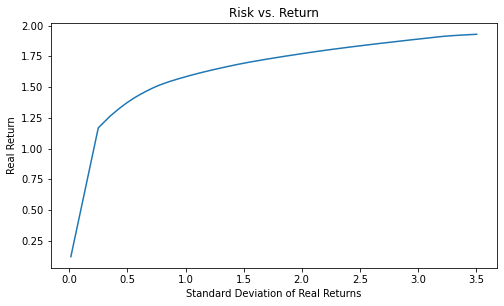

In [50]:
# plot frontier
plt.figure(figsize=(8, 4.5))
#plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")
plt.title("Risk vs. Return")

# plot the data
plt.plot(x,y);
